# 3. Advanced Analysis & Strategic Segmentation

**Objective**: To build upon the initial findings with more advanced techniques that provide unique, actionable insights.

In this notebook, we will:
1.  **Visualize Revenue Interactively**: Create a treemap to understand the complex relationship between channels, hotel ratings, and revenue.
2.  **Develop a Cancellation Risk Score**: Quantify the cancellation risk for each booking to enable proactive intervention.
3.  **Identify and Profile High-Value Guests**: Define what a "high-value" guest looks like to inform marketing and retention strategies.


In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('hotel_bookings_cleaned.csv')

sns.set_theme(style="whitegrid", palette="viridis")
plt.style.use('seaborn-v0_8-whitegrid')

display(df.head(3))


,customer_id,property_id,city,star_rating,booking_date,check_in_date,check_out_date,room_type,num_rooms_booked,stay_type,...,travel_date,cashback,coupon_redeem,Coupon USed?,length_of_stay,is_cancelled,avg_daily_rate,booking_year,booking_month,booking_day_of_week
0,492,3,San Francisco,4,2024-04-01,2024-05-24,2024-05-26,Standard,1,Leisure,...,2024-03-04,5.374694,0.0,No,2.0,0,9680.495160,2024,4,0
1,180,3,Dallas,3,2024-04-01,2024-05-10,2024-05-17,Deluxe,1,Leisure,...,2024-07-19,7.161033,0.0,No,7.0,0,876.714160,2024,4,0
2,50,5,Dallas,3,2024-04-01,2024-05-31,2024-06-05,Deluxe,1,Business,...,2024-03-22,0.000000,0.0,No,5.0,0,4540.399092,2024,4,0


### 1. Interactive Revenue Treemap

Here, we can see the total revenue (`total_booking_value`) broken down by the primary `booking_channel` and then by the `star_rating` within each channel. This provides a clear, at-a-glance view of where the most revenue is generated.

**Instructions**: Hover over the rectangles to see the details. You can also click on a channel to zoom in.


In [2]:
df_confirmed = df[df['is_cancelled'] == 0]

fig = px.treemap(df_confirmed, 
                 path=[px.Constant("All Channels"), 'booking_channel', 'star_rating'], 
                 values='booking_value',
                 color='avg_daily_rate',
                 hover_data=['star_rating'],
                 color_continuous_scale='YlGnBu',
                 title='Hierarchical View of Revenue by Channel and Star Rating')

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()


### 2. Cancellation Risk Score

To make our analysis more actionable, we can create a `CancellationRiskScore`. This is a simple, rule-based score that quantifies how likely a booking is to be cancelled based on the risk factors we've identified.

**Scoring Logic**:
*   **Lead Time**: +1 point if booked > 90 days in advance.
*   **Channel**: +1 point if booked via 'Online Travel Agent'.
*   **Hotel Tier**: +1 point if it's a 5-star hotel.

A higher score indicates a higher risk of cancellation.


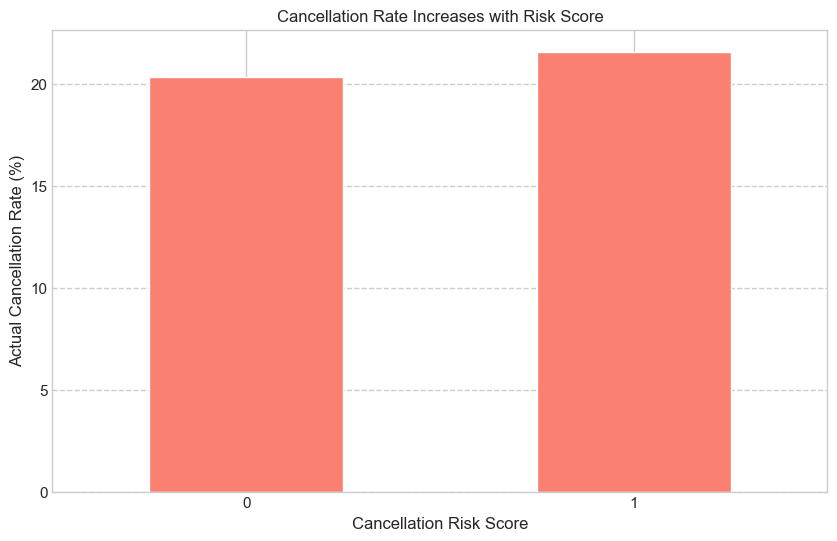

In [3]:
def calculate_risk_score(row):
    score = 0
    # Convert date strings to datetime objects and calculate days before check-in
    booking_date = pd.to_datetime(row['booking_date'])
    check_in_date = pd.to_datetime(row['check_in_date'])
    days_before_checkin = (check_in_date - booking_date).days
    if days_before_checkin > 90:
        score += 1
    if row['booking_channel'] == 'Online Travel Agent':
        score += 1
    if row['star_rating'] == 5:
        score += 1
    return score

df['CancellationRiskScore'] = df.apply(calculate_risk_score, axis=1)

risk_analysis = df.groupby('CancellationRiskScore')['is_cancelled'].mean() * 100

plt.figure(figsize=(10, 6))
risk_analysis.plot(kind='bar', color='salmon')
plt.title('Cancellation Rate Increases with Risk Score')
plt.xlabel('Cancellation Risk Score')
plt.ylabel('Actual Cancellation Rate (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()


### 3. High-Value Guest Profile

Finally, let's identify our "ideal" or "high-value" guests. These are customers who bring in significant revenue and have a low risk of cancelling.

**Definition**:
*   **Confirmed Booking**: `is_cancelled == 0`
*   **High Revenue**: `total_booking_value` is in the top 25% (75th percentile) of all bookings.

By analyzing the characteristics of this group, we can create a profile to target in marketing campaigns.


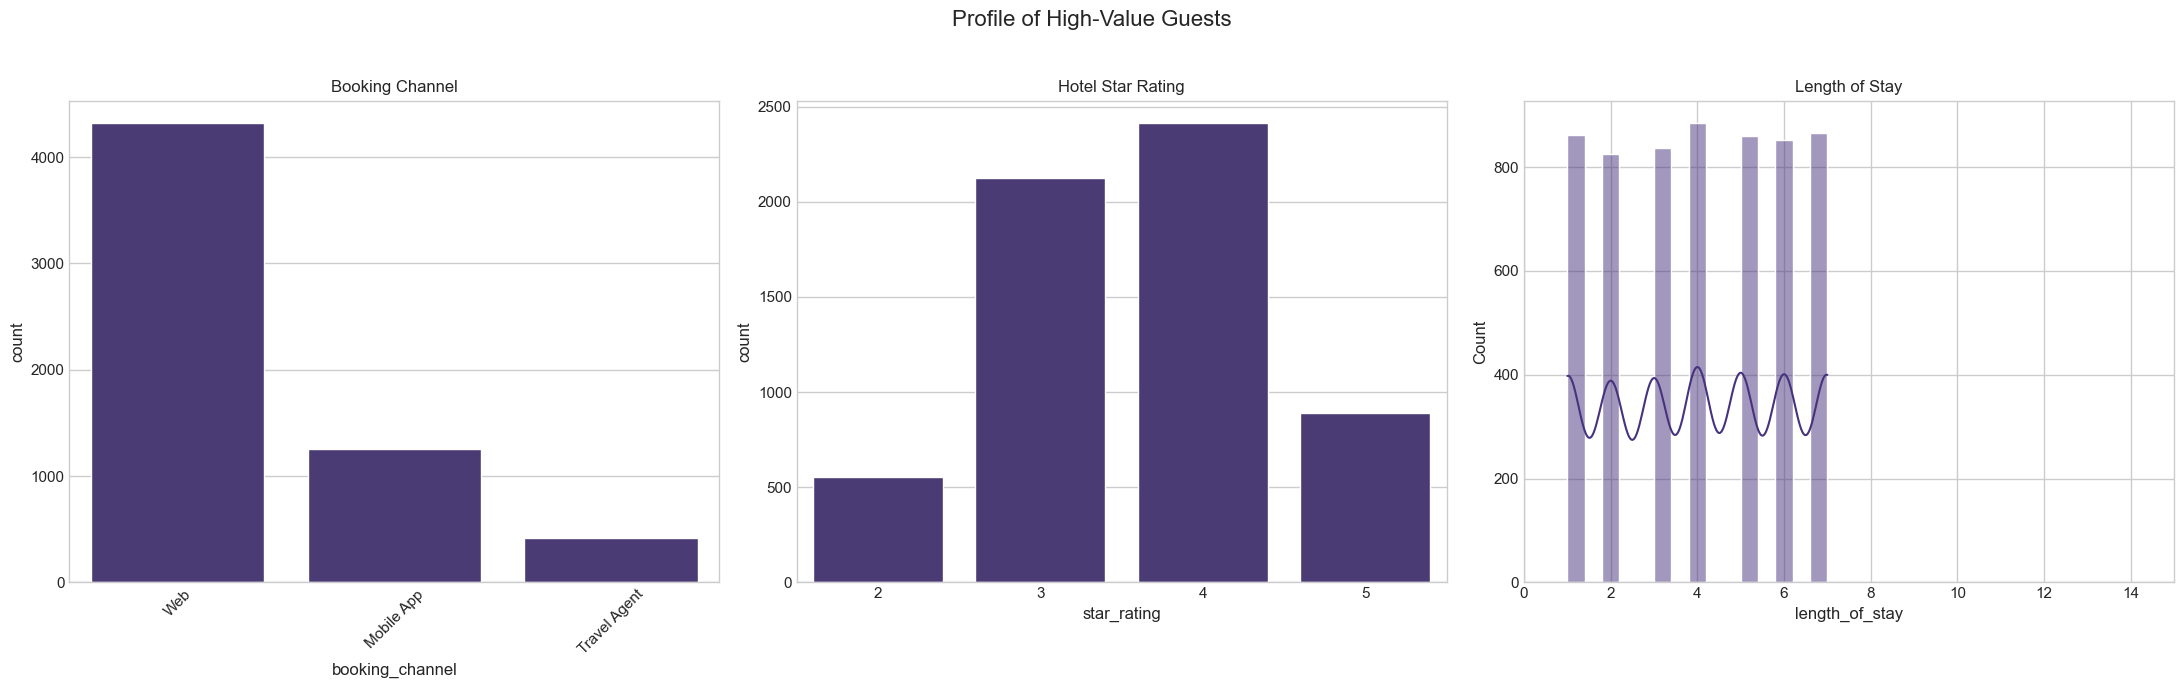

In [4]:
revenue_threshold = df['booking_value'].quantile(0.75)

high_value_guests = df[
    (df['is_cancelled'] == 0) & 
    (df['booking_value'] >= revenue_threshold)
]

fig, axes = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Profile of High-Value Guests', fontsize=16)

sns.countplot(ax=axes[0], data=high_value_guests, x='booking_channel', order=df['booking_channel'].value_counts().index)
axes[0].set_title('Booking Channel')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(ax=axes[1], data=high_value_guests, x='star_rating')
axes[1].set_title('Hotel Star Rating')

sns.histplot(high_value_guests['length_of_stay'], ax=axes[2], bins=15, kde=True)
axes[2].set_title('Length of Stay')
axes[2].set_xlim(0, 15)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
